**MobileNetV2**
 MobileNet is a family of deep learning architectures designed for efficient on-device vision applications, especially on mobile and embedded devices. While MobileNet is often used for tasks like image classification, object detection, and image segmentation, it can also serve as a classifier. MobileNet models are often pretrained on large-scale image datasets, such as ImageNet, to learn general features from a wide range of images.
 we choose mobilenetv2 variant

** Input Layer:** MobileNetV2 typically takes an RGB image as input, with a common input size of 224x224 pixels.

**Convolutional Blocks**: MobileNetV2 primarily consists of a series of convolutional building blocks. Each block contains depthwise separable convolutions, which are the key innovation behind MobileNet's efficiency. A depthwise separable convolution is split into two parts:

**a. Depthwise Convolution:** In this step, each input channel is convolved separately with its own set of filters, resulting in multiple feature maps.

**b. Pointwise Convolution:** This is a 1x1 convolution that combines the output feature maps from the depthwise convolution to produce the final output.

**Global Average Pooling**: After the convolutional layers, a global average pooling layer is often applied to obtain a fixed-size feature vector.

 Install the kaggle python package using pip

In [ ]:
pip install kaggle


You can download the JSON file by generating an  token on Kaggle and then selecting the downloaded JSON file when you upload it.

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 67 bytes


In [ ]:
!mkdir -p /root/.kaggle
!mv kaggle.json /root/.kaggle/

Download the dataset by using API command of dataset

In [ ]:
!kaggle datasets download -d navoneel/brain-mri-images-for-brain-tumor-detection

 60% 9.00M/15.1M [00:00<00:00, 63.8MB/s]
100% 15.1M/15.1M [00:00<00:00, 92.1MB/s]


Import the required libraries

In [ ]:
import tensorflow as tf
from zipfile import ZipFile
import os,glob
import cv2
from tqdm._tqdm_notebook import tqdm_notebook as tqdm
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Convolution2D, Dropout, Dense,MaxPooling2D
from keras.layers import BatchNormalization
from keras.layers import MaxPooling2D
from keras.layers import Flatten

<ipython-input-5-4addd0ae159c>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  from tqdm._tqdm_notebook import tqdm_notebook as tqdm


In [ ]:
from zipfile import ZipFile
file_name = "/content/brain-mri-images-for-brain-tumor-detection.zip"
with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

Done


Split the dataset into two lists, 'X' for training data and 'y' for testing data.Load images from both 'yes' and 'no' classes, and then display the corresponding labels.

In [ ]:
import cv2
import os
from tqdm import tqdm

# Initialize lists to store images and labels
X = []
y = []

# Directory for 'yes' class
os.chdir('/content/brain_tumor_dataset/yes')
for i in tqdm(os.listdir()):
    img = cv2.imread(i)
    if img is not None:
        img = cv2.resize(img, (224, 224))
        X.append(img)
        y.append(1)  # Assign label 1 for 'yes' class
    else:
        print(f"Failed to read image: {i}")

# Directory for 'no' class
os.chdir('/content/brain_tumor_dataset/no')
for i in tqdm(os.listdir()):
    img = cv2.imread(i)
    if img is not None:
        img = cv2.resize(img, (224, 224))
        X.append(img)
        y.append(0)  # Assign label 0 for 'no' class

# Print the labels
print(y)

100%|██████████| 98/98 [00:00<00:00, 638.79it/s]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [ ]:
print(img.shape)

(224, 224, 3)


plot the training images

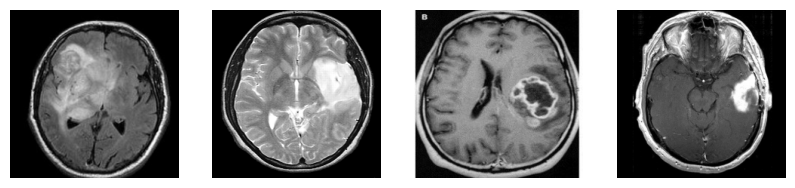

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(X[i], cmap="gray")
    plt.axis('off')
plt.show()

print the shape of an images of  the x_train and X_test

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
print ("Shape of an image in X_train: ", X_train[0].shape)
print ("Shape of an image in X_test: ", X_test[0].shape)

Shape of an image in X_train:  (224, 224, 3)
Shape of an image in X_test:  (224, 224, 3)


In [ ]:
le = preprocessing.LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)
y_train = tf.keras.utils.to_categorical(y_train, num_classes=2)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=2)
y_train = np.array(y_train)
X_train = np.array(X_train)
y_test = np.array(y_test)
X_test = np.array(X_test)

In [ ]:
print("X_train Shape: ", X_train.shape)
print("X_test Shape: ", X_test.shape)
print("y_train Shape: ", y_train.shape)
print("y_test Shape: ", y_test.shape)

X_train Shape:  (169, 224, 224, 3)
X_test Shape:  (84, 224, 224, 3)
y_train Shape:  (169, 2)
y_test Shape:  (84, 2)


import the MobileNetV2

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

# Define the input shape for your data
input_shape = (224, 224, 3)  # You can adjust the input size as needed

# Load the MobileNetV2 base model (pre-trained on ImageNet)
base_model = MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')

# Freeze the layers in the base model (optional)
for layer in base_model.layers:
    layer.trainable = False

# Add your custom layers on top of the base model
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(128, activation='relu')(x)
output = Dense(2, activation='softmax')(x)  # Replace num_classes with the number of your output classes

# Create your custom model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# You can now train and evaluate your model using your dataset

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
for (i,layer) in enumerate(model.layers):
    print(str(i) + " "+ layer.__class__.__name__, layer.trainable)

0 InputLayer False
1 Conv2D False
2 BatchNormalization False
3 ReLU False
4 DepthwiseConv2D False
5 BatchNormalization False
6 ReLU False
7 Conv2D False
8 BatchNormalization False
9 Conv2D False
10 BatchNormalization False
11 ReLU False
12 ZeroPadding2D False
13 DepthwiseConv2D False
14 BatchNormalization False
15 ReLU False
16 Conv2D False
17 BatchNormalization False
18 Conv2D False
19 BatchNormalization False
20 ReLU False
21 DepthwiseConv2D False
22 BatchNormalization False
23 ReLU False
24 Conv2D False
25 BatchNormalization False
26 Add False
27 Conv2D False
28 BatchNormalization False
29 ReLU False
30 ZeroPadding2D False
31 DepthwiseConv2D False
32 BatchNormalization False
33 ReLU False
34 Conv2D False
35 BatchNormalization False
36 Conv2D False
37 BatchNormalization False
38 ReLU False
39 DepthwiseConv2D False
40 BatchNormalization False
41 ReLU False
42 Conv2D False
43 BatchNormalization False
44 Add False
45 Conv2D False
46 BatchNormalization False
47 ReLU False
48 DepthwiseCon

In [ ]:
def lw(bottom_model, num_classes):
    """creates the top or head of the model that will be
    placed ontop of the bottom layers"""

    top_model = bottom_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(512,activation='relu')(top_model)
    top_model = Dense(num_classes,activation='softmax')(top_model)
    return top_model

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D

from keras.models import Model
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']        

In [ ]:
pip install visualkeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.0/993.0 kB 21.8 MB/s eta 0:00:00


Visualisation

In [ ]:
import visualkeras
model=base_model

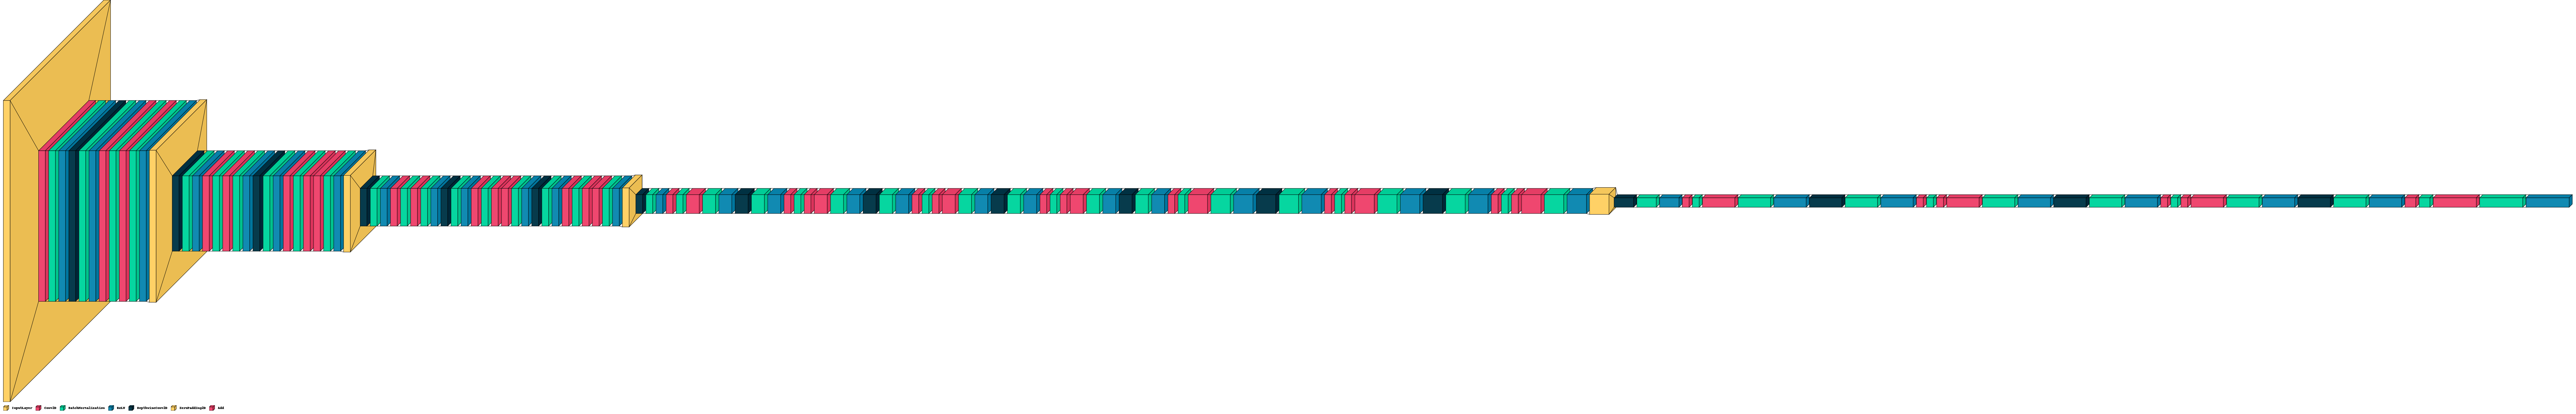

In [ ]:
from pickle import TRUE
from IPython.display import display
from PIL import Image
visualkeras.layered_view(base_model).show() # display using your system viewer
visualkeras.layered_view(base_model, to_file='output.png') # write to disk
visualkeras.layered_view(base_model, to_file='output.png',legend=True).show() # write and show
img = Image.open('output.png')
display(img)

Training

In [ ]:
from tensorflow.keras.models import Model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer='adam', loss = 'categorical_crossentropy',metrics = ['accuracy'])

In [ ]:
history = model.fit(X_train,y_train,
                    epochs=10,
                    validation_data=(X_test,y_test),
                    verbose = 1,
                    initial_epoch=0)

Epoch 1/10
6/6 [==============================] - 21s 3s/step - loss: 0.6706 - accuracy: 0.6746 - val_loss: 0.6580 - val_accuracy: 0.7143
Epoch 2/10
6/6 [==============================] - 18s 3s/step - loss: 0.4589 - accuracy: 0.7633 - val_loss: 0.6910 - val_accuracy: 0.6905
Epoch 3/10
6/6 [==============================] - 12s 2s/step - loss: 0.3285 - accuracy: 0.8757 - val_loss: 0.5212 - val_accuracy: 0.7857
Epoch 4/10
6/6 [==============================] - 12s 2s/step - loss: 0.2238 - accuracy: 0.9231 - val_loss: 0.5278 - val_accuracy: 0.7976
Epoch 5/10
6/6 [==============================] - 12s 2s/step - loss: 0.1958 - accuracy: 0.9349 - val_loss: 0.5533 - val_accuracy: 0.7738
Epoch 6/10
6/6 [==============================] - 10s 2s/step - loss: 0.1641 - accuracy: 0.9467 - val_loss: 0.5323 - val_accuracy: 0.8333
Epoch 7/10
6/6 [==============================] - 8s 1s/step - loss: 0.1416 - accuracy: 0.9467 - val_loss: 0.5604 - val_accuracy: 0.7976
Epoch 8/10
6/6 [===================

Testing

1/1 [==============================] - 1s 911ms/step


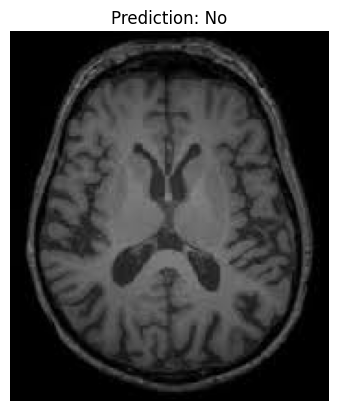

In [ ]:
from keras.preprocessing import image
import matplotlib.pyplot as plt

# Load and preprocess the test image
test_image_path="/content/no/10 no.jpg"  # Replace with the path to your test image
test_image = cv2.imread(test_image_path)
test_image = cv2.resize(test_image, (224, 224))
test_image = np.expand_dims(test_image, axis=0)  # Add a batch dimension
test_image = test_image / 255.0  # Normalize pixel values

# Make predictions
predictions = model.predict(test_image)

# Interpret the prediction result
if predictions[0][0] > predictions[0][1]:
    prediction_label = "No"
else:
    prediction_label = "Yes"

# Display the test image along with the predicted label
plt.imshow(cv2.cvtColor(cv2.imread(test_image_path), cv2.COLOR_BGR2RGB))
plt.title(f"Prediction: {prediction_label}")
plt.axis('off')
plt.show()